###  importing relevant libraries

In [17]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
%matplotlib inline
from numpy import array
from random import random
from sklearn import metrics
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier


from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB#57
from sklearn.naive_bayes import GaussianNB#52
from sklearn.naive_bayes import MultinomialNB#56
from sklearn.naive_bayes import CategoricalNB

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
import csv
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn
import time



### Discovering Labels

In [19]:
def target_name(name):
    df = pd.read_csv(name,usecols=["Label"])
    target_names=sorted(list(df["Label"].unique()))
    return target_names

### Hyperparameters of machine learning algorithm.

In [20]:
ml_list={"NB":CategoricalNB(alpha=1e-09),
"DT" :DecisionTreeClassifier(criterion='entropy', max_depth=27.0,
                       max_features=19,min_samples_split= 8),  
"RF":RandomForestClassifier(bootstrap= False, criterion= "entropy", max_depth= 29.0, max_features= 7, min_samples_split= 9, n_estimators= 80)}

# Aggregation Algorithm notmal

In [21]:
altime=0
def most_frequent(List): 
    return max(set(List), key = List.count) 

def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))





def create_exception(df): 
    exception_list=[]
    dominant_mac=[]
    for i in df['aggregated'].unique():
        k=df[df['aggregated']==i]
        for ii in ['MAC']:
            hist = {}
            for x in k[ii].values:
                hist[x] = hist.get(x, 0) + 1
            hist=dict(sorted(hist.items(), key=lambda item: item[1],reverse=True))
            temp=next(iter(hist))
            if temp not in dominant_mac:
                dominant_mac.append(temp)
            else:
                exception_list.append(temp)
    return exception_list




def merged(m_test,predict,step,mixed):
    second=time.time()
    mac_test=[]
    for q in m_test.index:
        mac_test.append(m_test[q])

    d_list=sorted(list(m_test.unique()))
    devices={}
    for q in d_list:
        devices[q]=[]    


    new_y=[0]*len(m_test)

    for q,qq in enumerate (mac_test):
        devices[qq].append(q)
    for q in devices:
        a = [devices[q][j:j + step] for j in range(0, len(devices[q]), step)]  
        for qq in a:
            step_list=[]
            for qqq in qq:
                step_list.append(predict[qqq])
            add=most_frequent(list(step_list))
            for qqq in qq:
                new_y[qqq]=add
    results=pd.DataFrame(m_test)
    results["aggregated"]=new_y # Only aggregated results
    results["normal"]=predict
    
    #MIXED METHOD
    if mixed:
        exception=create_exception(results)
        for q in exception:
            results.loc[results.MAC == q, 'aggregated'] = results['normal']

    return results["aggregated"].values,time.time()-second














## Calculation of evaluations

In [22]:
def score(altime,train_time,test_time,predict,y_test,class_based_results,i,cv,dname,ii):
    precision=[]
    recall=[]
    f1=[]
    accuracy=[]
    total_time=[]
    kappa=[]
    accuracy_b=[]
    
    rc=sklearn.metrics.recall_score(y_test, predict,average= "macro")
    pr=sklearn.metrics.precision_score(y_test, predict,average= "macro")
    f_1=sklearn.metrics.f1_score(y_test, predict,average= "macro")        
    report = classification_report(y_test, predict, target_names=target_names,output_dict=True)
    cr = pd.DataFrame(report).transpose()
    if class_based_results.empty:
        class_based_results =cr
    else:
        class_based_results = class_based_results.add(cr, fill_value=0)
    precision.append(float(pr))
    recall.append(float(rc))
    f1.append(float(f_1))
    accuracy_b.append(balanced_accuracy_score( y_test,predict))
    accuracy.append(accuracy_score(y_test, predict))

    kappa.append(round(float(sklearn.metrics.cohen_kappa_score(y_test, predict, 
    labels=None, weights=None, sample_weight=None)),15))
    print ('%-15s %-3s %-3s %-6s  %-5s %-5s %-5s %-5s %-8s %-5s %-8s %-8s%-8s%-8s' % (dname,i,cv,ii[0:6],str(round(np.mean(accuracy),2)),str(round(np.mean(accuracy_b),2)),
        str(round(np.mean(precision),2)), str(round(np.mean(recall),2)),str(round(np.mean(f1),4)), 
        str(round(np.mean(kappa),2)),str(round(np.mean(train_time),2)),str(round(np.mean(test_time),2)),str(round(np.mean(test_time)+np.mean(train_time),2)),str(round(np.mean(altime),2))))
    lines=(str(dname)+","+str(i)+","+str(cv)+","+str(ii)+","+str(round(np.mean(accuracy),15))+","+str(round(np.mean(accuracy_b),15))+","+str(round(np.mean(precision),15))+","+ str(round(np.mean(recall),15))+","+str(round(np.mean(f1),15))+","+str(round(np.mean(kappa),15))+","+str(round(np.mean(train_time),15))+","+str(round(np.mean(test_time),15))+","+str(altime)+"\n")
    return lines,class_based_results

In [23]:
def ML(loop1,loop2,output_csv,cols,step,mixed,dname):

    ths = open(output_csv, "w")
    ths.write("Dataset,T,CV,ML algorithm,Acc,b_Acc,Precision, Recall , F1-score, kappa ,tra-Time,test-Time,Al-Time\n")
    

    from sklearn.metrics import balanced_accuracy_score
    from sklearn.preprocessing import Normalizer
    
    for ii in ml_list:
        print ('%-15s %-3s %-3s %-6s  %-5s %-5s %-5s %-5s %-8s %-5s %-8s %-8s%-8s%-8s'%
               ("Dataset","T","CV","ML alg","Acc","b_Acc","Prec", "Rec" , "F1", "kap" ,"tra-T","test-T","total","al-time"))
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        if ii in ["GB","SVM"]: #for slow algorithms.
            repetition=10 
        else:
            repetition=100

        for i in range(repetition):



            #TRAIN
            df = pd.read_csv(loop1,usecols=cols)
            try:df=df.replace({"Protocol": Protocol})
            except:pass
            m_train=df["MAC"]
            del df["MAC"]
            X_train =df[df.columns[0:-1]]
            X_train=np.array(X_train)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_train=df[df.columns[-1]].cat.codes  

            #TEST
            df = pd.read_csv(loop2,usecols=cols)
            try:df=df.replace({"Protocol": Protocol})
            except:pass
            df = shuffle(df)
            m_test=df["MAC"]
            del df["MAC"]
            X_test =df[df.columns[0:-1]]
            X_test=np.array(X_test)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_test=df[df.columns[-1]].cat.codes




            results_y=[]
            cv+=1
            results_y.append(y_test)


     
   

            #machine learning algorithm is applied in this section
            clf = ml_list[ii]#choose algorithm from ml_list dictionary
            second=time.time()
            clf.fit(X_train, y_train)
            train_time=(float((time.time()-second)) )
            second=time.time()
            predict =clf.predict(X_test)
            test_time=(float((time.time()-second)) )
            if step==1:
                altime=0
                lines,class_based_results=score(altime,train_time,test_time,predict,y_test,class_based_results,i,cv,dname,ii)
            else:
                predict,altime=merged(m_test,predict,step,mixed)
                lines,class_based_results=score(altime,train_time,test_time,predict,y_test,class_based_results,i,cv,dname,ii)
            ths.write (lines)


            df_cm = pd.DataFrame(confusion_matrix(y_test, predict))
            if cm.empty:
                cm =df_cm
            else:
                cm = cm.add(df_cm, fill_value=0)
            
        class_based_results=class_based_results/repetition
        print(class_based_results)
        class_based_results.to_csv("class_based_results.csv")
        if True:
            cm=cm//repetition
            graph_name=output_csv+ii+"_confusion matrix.pdf"   
            plt.figure(figsize = (40,28))
            sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True, fmt='g')
            plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
            plt.show()
            #print(cm)
            print("\n\n\n")             


            
            
            
            
            
            
            


    ths.close()  

# Machine learning applications 

# Aalto Dataset

In [25]:
feature= ['pck_size', 'Ether_type', 'LLC_ctrl', 'EAPOL_version', 'EAPOL_type', 'IP_ihl', 'IP_tos', 'IP_len', 'IP_flags', 'IP_DF', 'IP_ttl', 'IP_options', 'ICMP_code', 'TCP_dataofs', 'TCP_FIN', 'TCP_ACK', 'TCP_window', 'UDP_len', 'DHCP_options', 'BOOTP_hlen', 'BOOTP_flags', 'BOOTP_sname', 'BOOTP_file', 'BOOTP_options', 'DNS_qr', 'DNS_rd', 'DNS_qdcount', 'dport_class', 'payload_bytes', 'entropy',
"MAC",
'Label']


In [26]:
ml_list={"DT" :DecisionTreeClassifier(criterion='entropy', max_depth=27.0,
                       max_features=23,min_samples_split= 6)}

In [ ]:
test='UNSW_test_IoTDevID.csv'
train='UNSW_train_IoTDevID.csv'



dataset="./UNSW/"
step=1



mixed=True
sayac=1
output_csv=dataset+str(sayac)+"_"+str(step)+"_"+str(mixed)+"new.csv"
target_names=target_name(test)
ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step))   


Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1       kap   tra-T    test-T  total   al-time 
UNSW_1          0   1   DT      0.85  0.82  0.88  0.82  0.8298   0.85  0.81     0.03    0.84    0.0     
UNSW_1          1   2   DT      0.86  0.82  0.88  0.82  0.8309   0.85  0.7      0.03    0.73    0.0     
UNSW_1          2   3   DT      0.86  0.82  0.88  0.82  0.8287   0.85  0.8      0.03    0.83    0.0     
UNSW_1          3   4   DT      0.86  0.82  0.88  0.82  0.8273   0.85  0.78     0.02    0.81    0.0     
UNSW_1          4   5   DT      0.86  0.82  0.87  0.82  0.8293   0.85  0.8      0.03    0.83    0.0     
UNSW_1          5   6   DT      0.86  0.82  0.88  0.82  0.8328   0.85  0.81     0.03    0.83    0.0     
UNSW_1          6   7   DT      0.85  0.82  0.88  0.82  0.8326   0.85  0.8      0.03    0.83    0.0     
UNSW_1          7   8   DT      0.85  0.82  0.87  0.82  0.8292   0.85  0.81     0.03    0.84    0.0     
UNSW_1          8   9   DT      0.86  0.82  0.87  0.82 

Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1       kap   tra-T    test-T  total   al-time 
UNSW_1          0   1   DT      0.87  0.83  0.89  0.83  0.8433   0.86  0.64     0.02    0.65    0.0     
UNSW_1          1   2   DT      0.87  0.83  0.88  0.83  0.8407   0.86  0.62     0.02    0.64    0.0     
UNSW_1          2   3   DT      0.87  0.83  0.9   0.83  0.8491   0.86  0.63     0.02    0.65    0.0     
UNSW_1          3   4   DT      0.87  0.84  0.89  0.84  0.8496   0.86  0.65     0.02    0.67    0.0     
UNSW_1          4   5   DT      0.87  0.83  0.89  0.83  0.8431   0.86  0.69     0.02    0.71    0.0     
UNSW_1          5   6   DT      0.87  0.83  0.89  0.83  0.8449   0.86  0.64     0.02    0.66    0.0     
UNSW_1          6   7   DT      0.87  0.83  0.89  0.83  0.8433   0.86  0.8      0.03    0.82    0.0     
UNSW_1          7   8   DT      0.87  0.83  0.89  0.83  0.8448   0.86  0.59     0.02    0.61    0.0     
UNSW_1          8   9   DT      0.87  0.84  0.89  0.84 

UNSW_1          78  79  DT      0.87  0.83  0.9   0.83  0.8493   0.86  0.6      0.02    0.62    0.0     
UNSW_1          79  80  DT      0.88  0.84  0.89  0.84  0.848    0.87  0.53     0.02    0.54    0.0     
UNSW_1          80  81  DT      0.87  0.83  0.88  0.83  0.8432   0.86  0.57     0.02    0.59    0.0     
UNSW_1          81  82  DT      0.87  0.84  0.89  0.84  0.8462   0.87  0.62     0.01    0.63    0.0     
UNSW_1          82  83  DT      0.87  0.84  0.89  0.84  0.846    0.86  0.58     0.02    0.6     0.0     
UNSW_1          83  84  DT      0.87  0.84  0.88  0.84  0.8461   0.87  0.61     0.02    0.63    0.0     
UNSW_1          84  85  DT      0.87  0.84  0.89  0.84  0.8479   0.86  0.57     0.02    0.58    0.0     
UNSW_1          85  86  DT      0.88  0.84  0.89  0.84  0.855    0.87  0.59     0.02    0.61    0.0     
UNSW_1          86  87  DT      0.87  0.84  0.89  0.84  0.8465   0.86  0.6      0.02    0.62    0.0     
UNSW_1          87  88  DT      0.87  0.83  0.9   0.83 

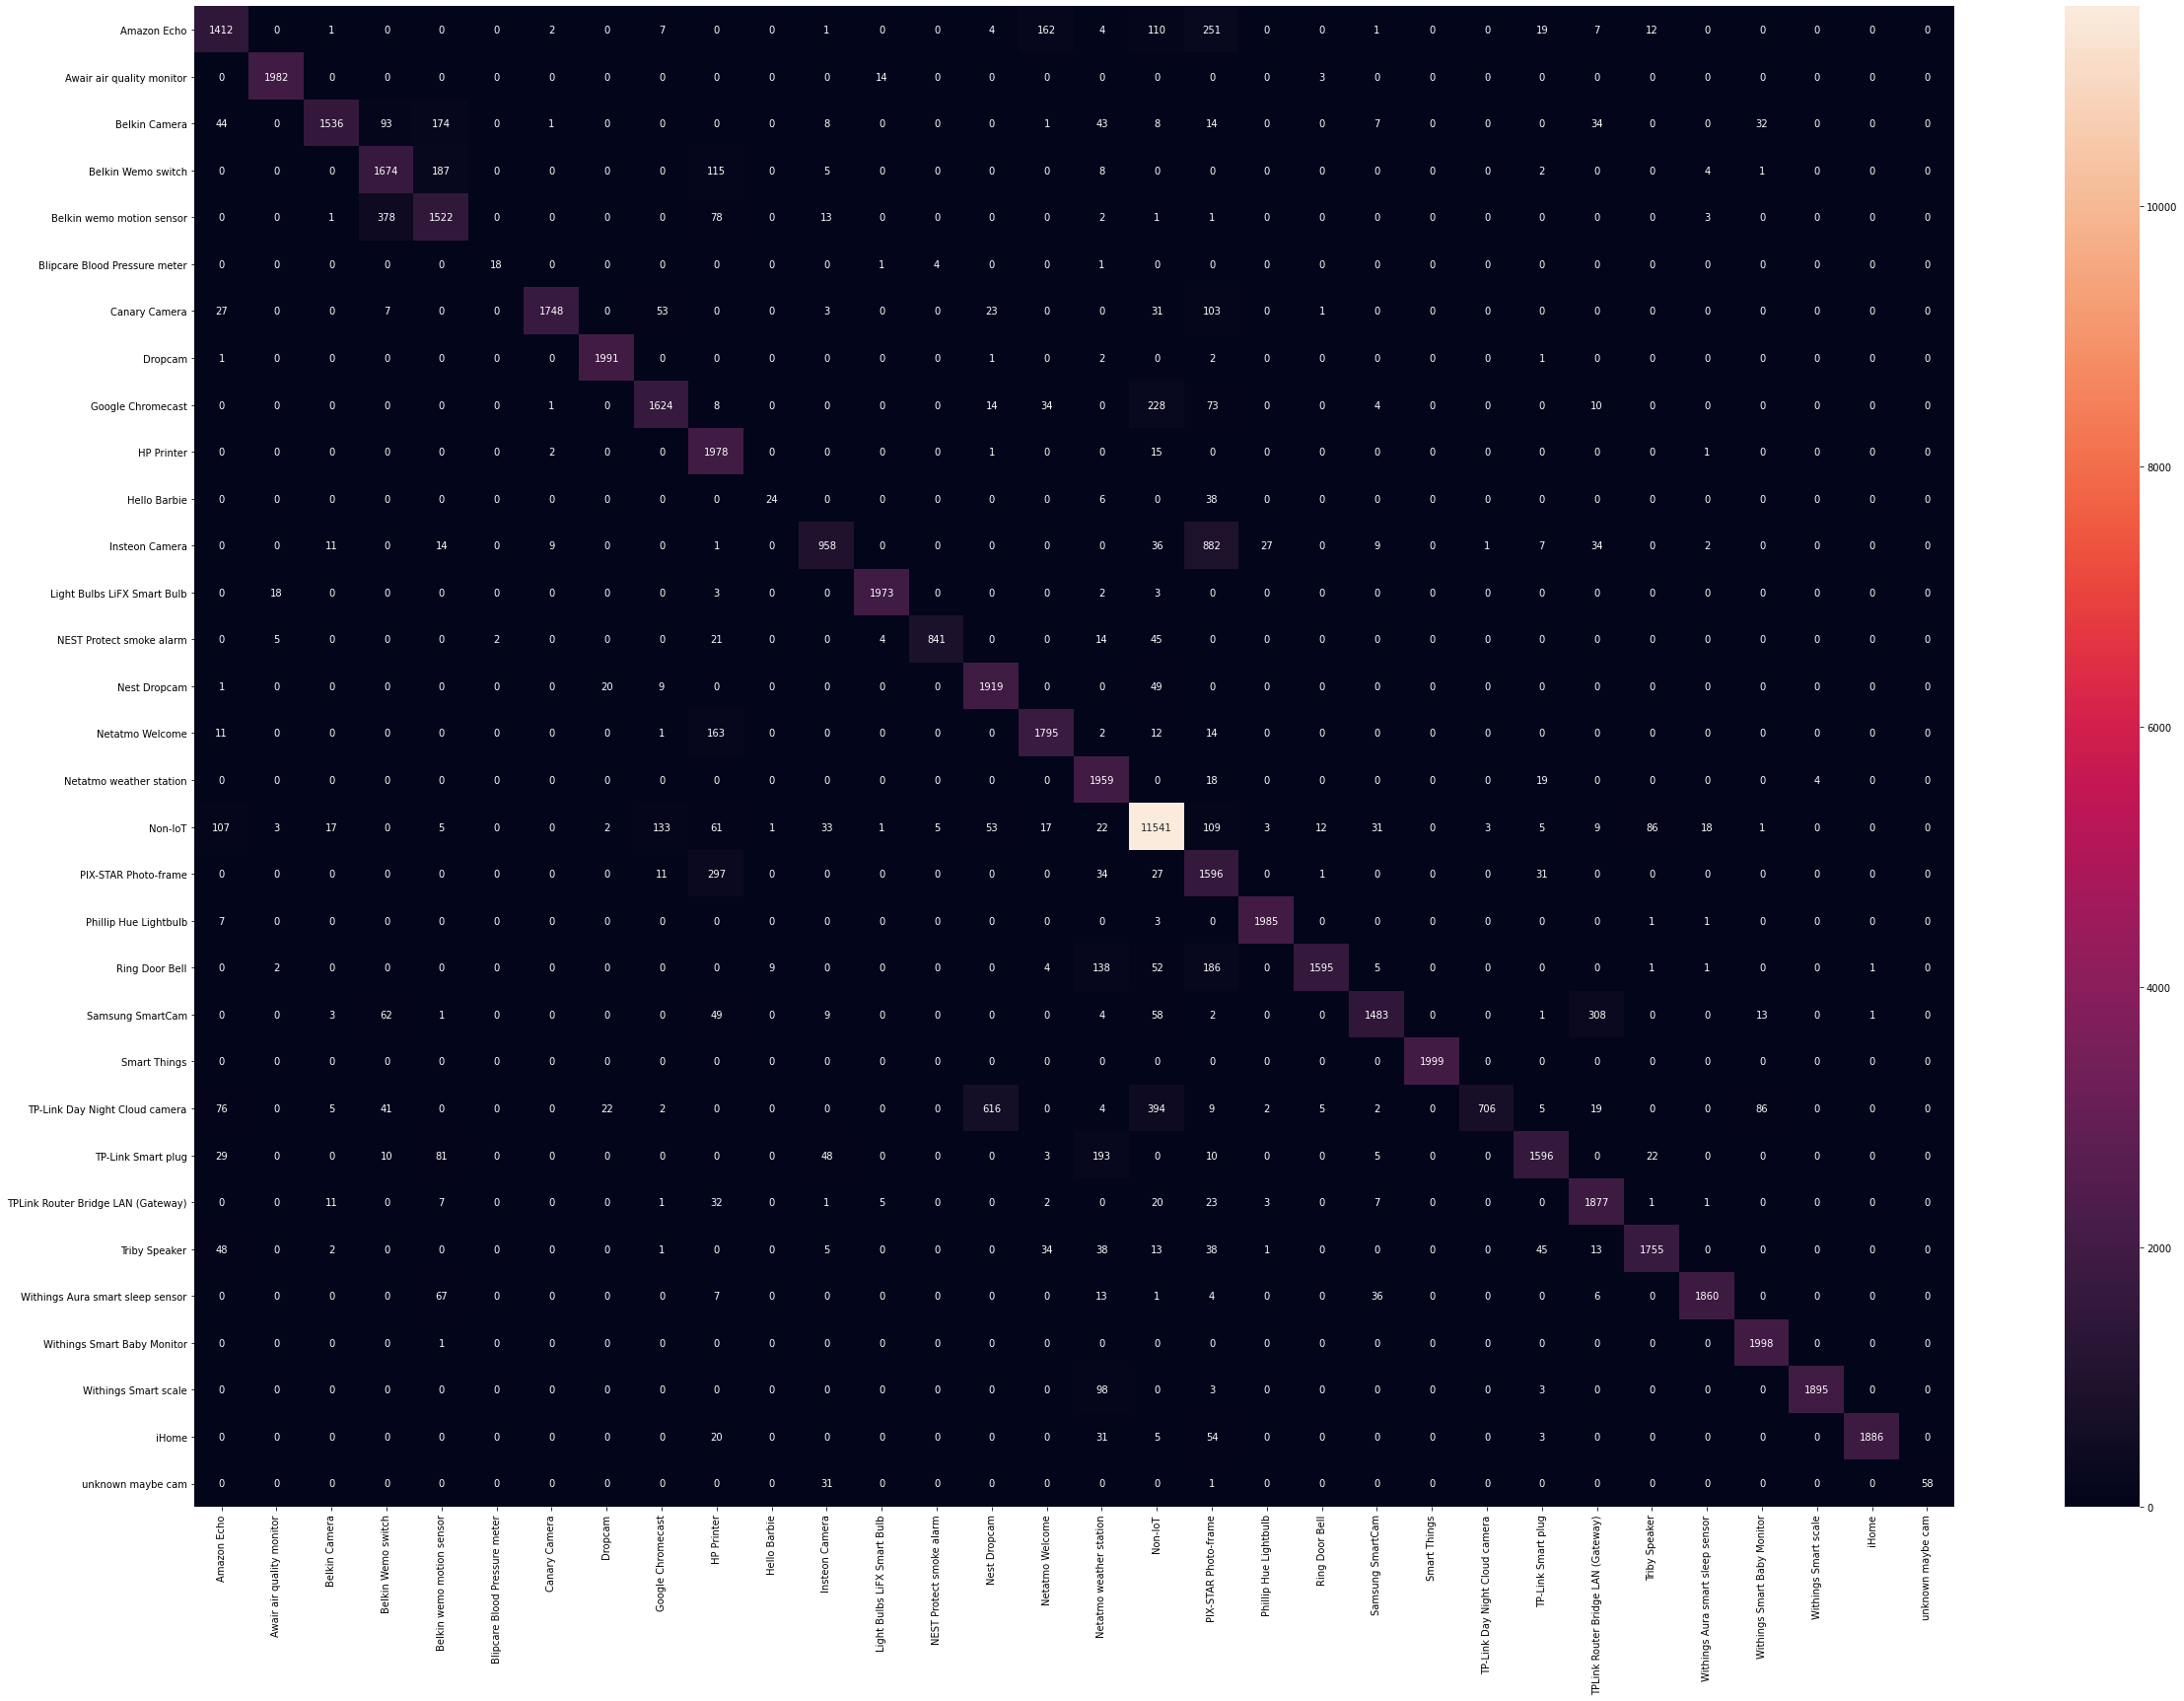

In [10]:
test='UNSW_test_IoTDevID.csv'
train='UNSW_train_IoTDevID.csv'

dataset="./UNSW/"
step=1



mixed=True
sayac=1
output_csv=dataset+str(sayac)+"_"+str(step)+"_"+str(mixed)+"new.csv"
target_names=target_name(test)
ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step))   


Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1       kap   tra-T    test-T  total   al-time 
UNSW_1          0   1   NB      0.82  0.78  0.83  0.78  0.7911   0.81  2.5      0.19    2.68    0.0     
UNSW_1          1   2   NB      0.82  0.78  0.83  0.78  0.7911   0.81  2.57     0.2     2.78    0.0     
UNSW_1          2   3   NB      0.82  0.78  0.83  0.78  0.7911   0.81  2.63     0.2     2.84    0.0     
UNSW_1          3   4   NB      0.82  0.78  0.83  0.78  0.7911   0.81  2.66     0.16    2.82    0.0     
UNSW_1          4   5   NB      0.82  0.78  0.83  0.78  0.7911   0.81  2.53     0.19    2.72    0.0     
UNSW_1          5   6   NB      0.82  0.78  0.83  0.78  0.7911   0.81  2.69     0.19    2.88    0.0     
UNSW_1          6   7   NB      0.82  0.78  0.83  0.78  0.7911   0.81  2.46     0.2     2.66    0.0     
UNSW_1          7   8   NB      0.82  0.78  0.83  0.78  0.7911   0.81  2.51     0.16    2.67    0.0     
UNSW_1          8   9   NB      0.82  0.78  0.83  0.78 

UNSW_1          78  79  NB      0.82  0.78  0.83  0.78  0.7911   0.81  2.08     0.15    2.23    0.0     
UNSW_1          79  80  NB      0.82  0.78  0.83  0.78  0.7911   0.81  2.14     0.15    2.29    0.0     
UNSW_1          80  81  NB      0.82  0.78  0.83  0.78  0.7911   0.81  2.08     0.15    2.23    0.0     
UNSW_1          81  82  NB      0.82  0.78  0.83  0.78  0.7911   0.81  2.07     0.15    2.22    0.0     
UNSW_1          82  83  NB      0.82  0.78  0.83  0.78  0.7911   0.81  2.12     0.16    2.28    0.0     
UNSW_1          83  84  NB      0.82  0.78  0.83  0.78  0.7911   0.81  2.07     0.15    2.22    0.0     
UNSW_1          84  85  NB      0.82  0.78  0.83  0.78  0.7911   0.81  2.13     0.15    2.28    0.0     
UNSW_1          85  86  NB      0.82  0.78  0.83  0.78  0.7911   0.81  2.08     0.15    2.22    0.0     
UNSW_1          86  87  NB      0.82  0.78  0.83  0.78  0.7911   0.81  2.07     0.15    2.21    0.0     
UNSW_1          87  88  NB      0.82  0.78  0.83  0.78 

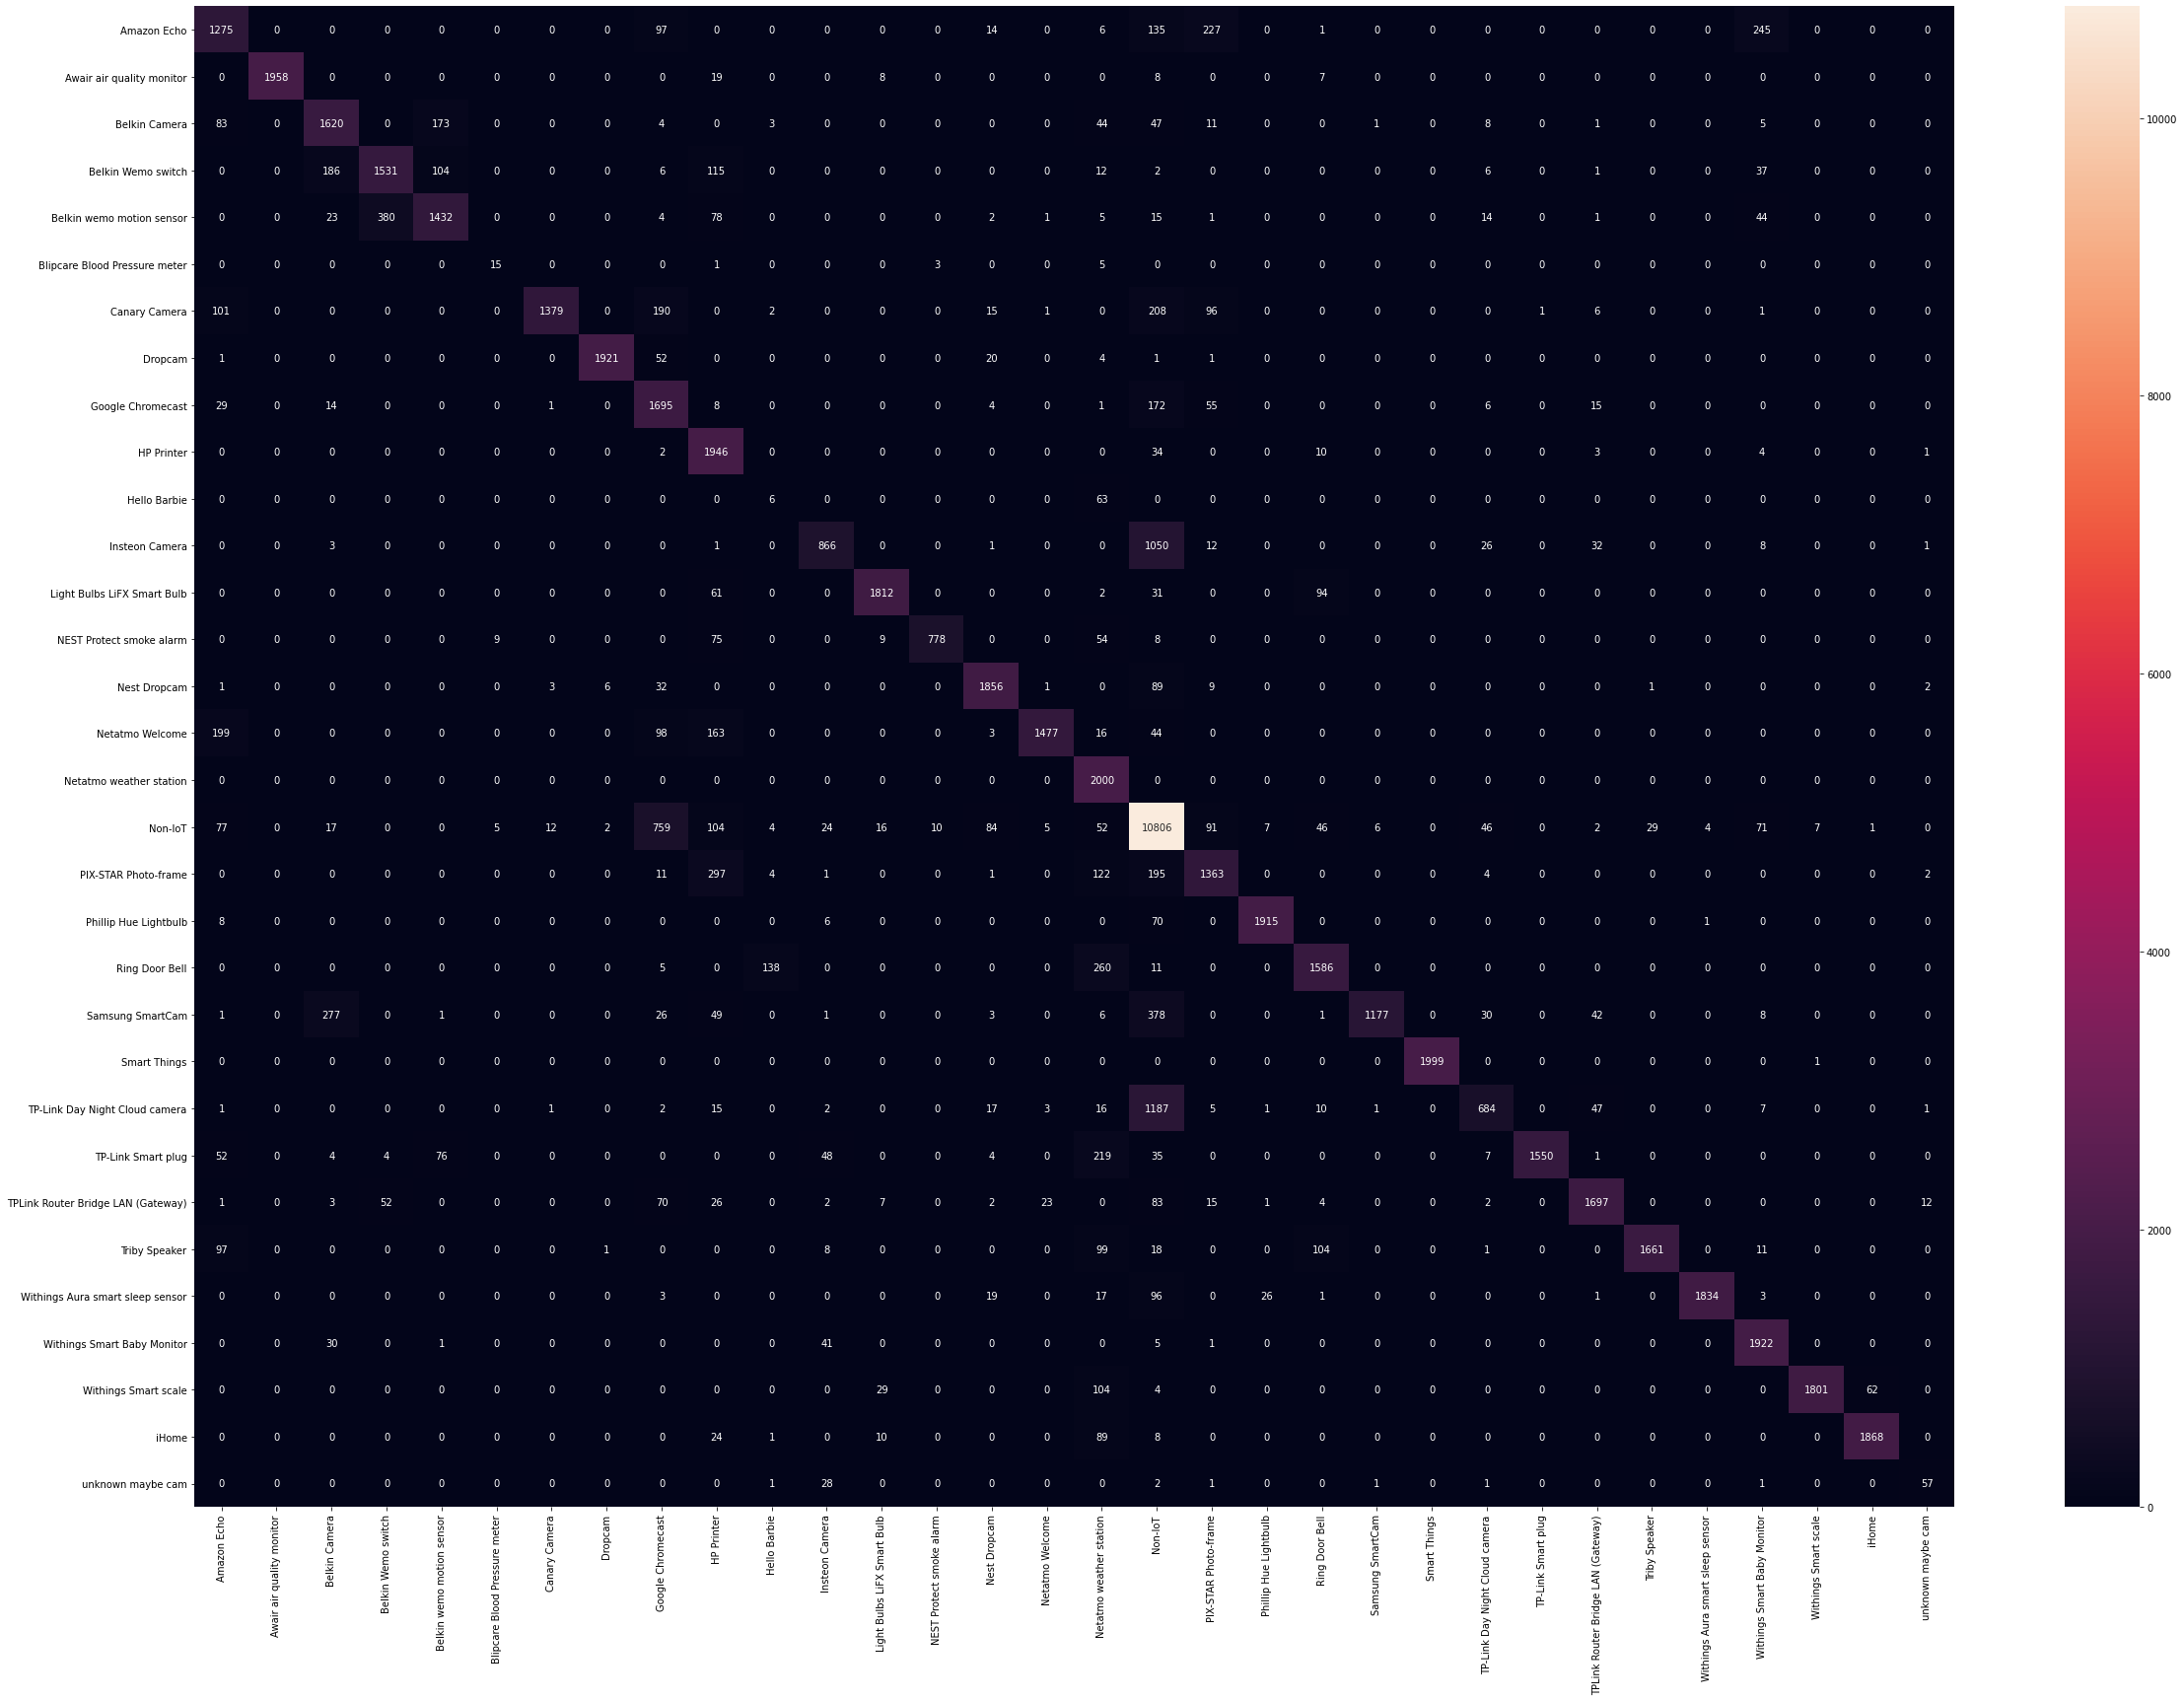





Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1       kap   tra-T    test-T  total   al-time 
UNSW_1          0   1   DT      0.87  0.83  0.87  0.83  0.8329   0.86  0.4      0.01    0.42    0.0     
UNSW_1          1   2   DT      0.87  0.83  0.89  0.83  0.8426   0.86  0.51     0.01    0.52    0.0     
UNSW_1          2   3   DT      0.87  0.83  0.88  0.83  0.8389   0.86  0.46     0.01    0.47    0.0     
UNSW_1          3   4   DT      0.87  0.83  0.88  0.83  0.8419   0.86  0.41     0.01    0.43    0.0     
UNSW_1          4   5   DT      0.87  0.84  0.88  0.84  0.8422   0.86  0.53     0.01    0.54    0.0     
UNSW_1          5   6   DT      0.87  0.84  0.89  0.84  0.8539   0.86  0.46     0.01    0.47    0.0     
UNSW_1          6   7   DT      0.88  0.84  0.89  0.84  0.8499   0.87  0.51     0.01    0.53    0.0     
UNSW_1          7   8   DT      0.87  0.83  0.88  0.83  0.842    0.86  0.41     0.01    0.43    0.0     
UNSW_1          8   9   DT      0.87  0.83  0.88  0

UNSW_1          77  78  DT      0.87  0.83  0.89  0.83  0.8437   0.86  0.46     0.01    0.47    0.0     
UNSW_1          78  79  DT      0.88  0.84  0.89  0.84  0.8532   0.87  0.55     0.01    0.57    0.0     
UNSW_1          79  80  DT      0.87  0.83  0.88  0.83  0.8421   0.86  0.46     0.01    0.47    0.0     
UNSW_1          80  81  DT      0.87  0.83  0.89  0.83  0.847    0.86  0.51     0.01    0.52    0.0     
UNSW_1          81  82  DT      0.86  0.83  0.88  0.83  0.8391   0.86  0.48     0.01    0.49    0.0     
UNSW_1          82  83  DT      0.88  0.84  0.89  0.84  0.8564   0.87  0.51     0.01    0.52    0.0     
UNSW_1          83  84  DT      0.87  0.83  0.88  0.83  0.8415   0.86  0.51     0.01    0.52    0.0     
UNSW_1          84  85  DT      0.88  0.84  0.89  0.84  0.8577   0.87  0.43     0.01    0.45    0.0     
UNSW_1          85  86  DT      0.87  0.83  0.88  0.83  0.8434   0.86  0.46     0.01    0.47    0.0     
UNSW_1          86  87  DT      0.87  0.83  0.89  0.83 

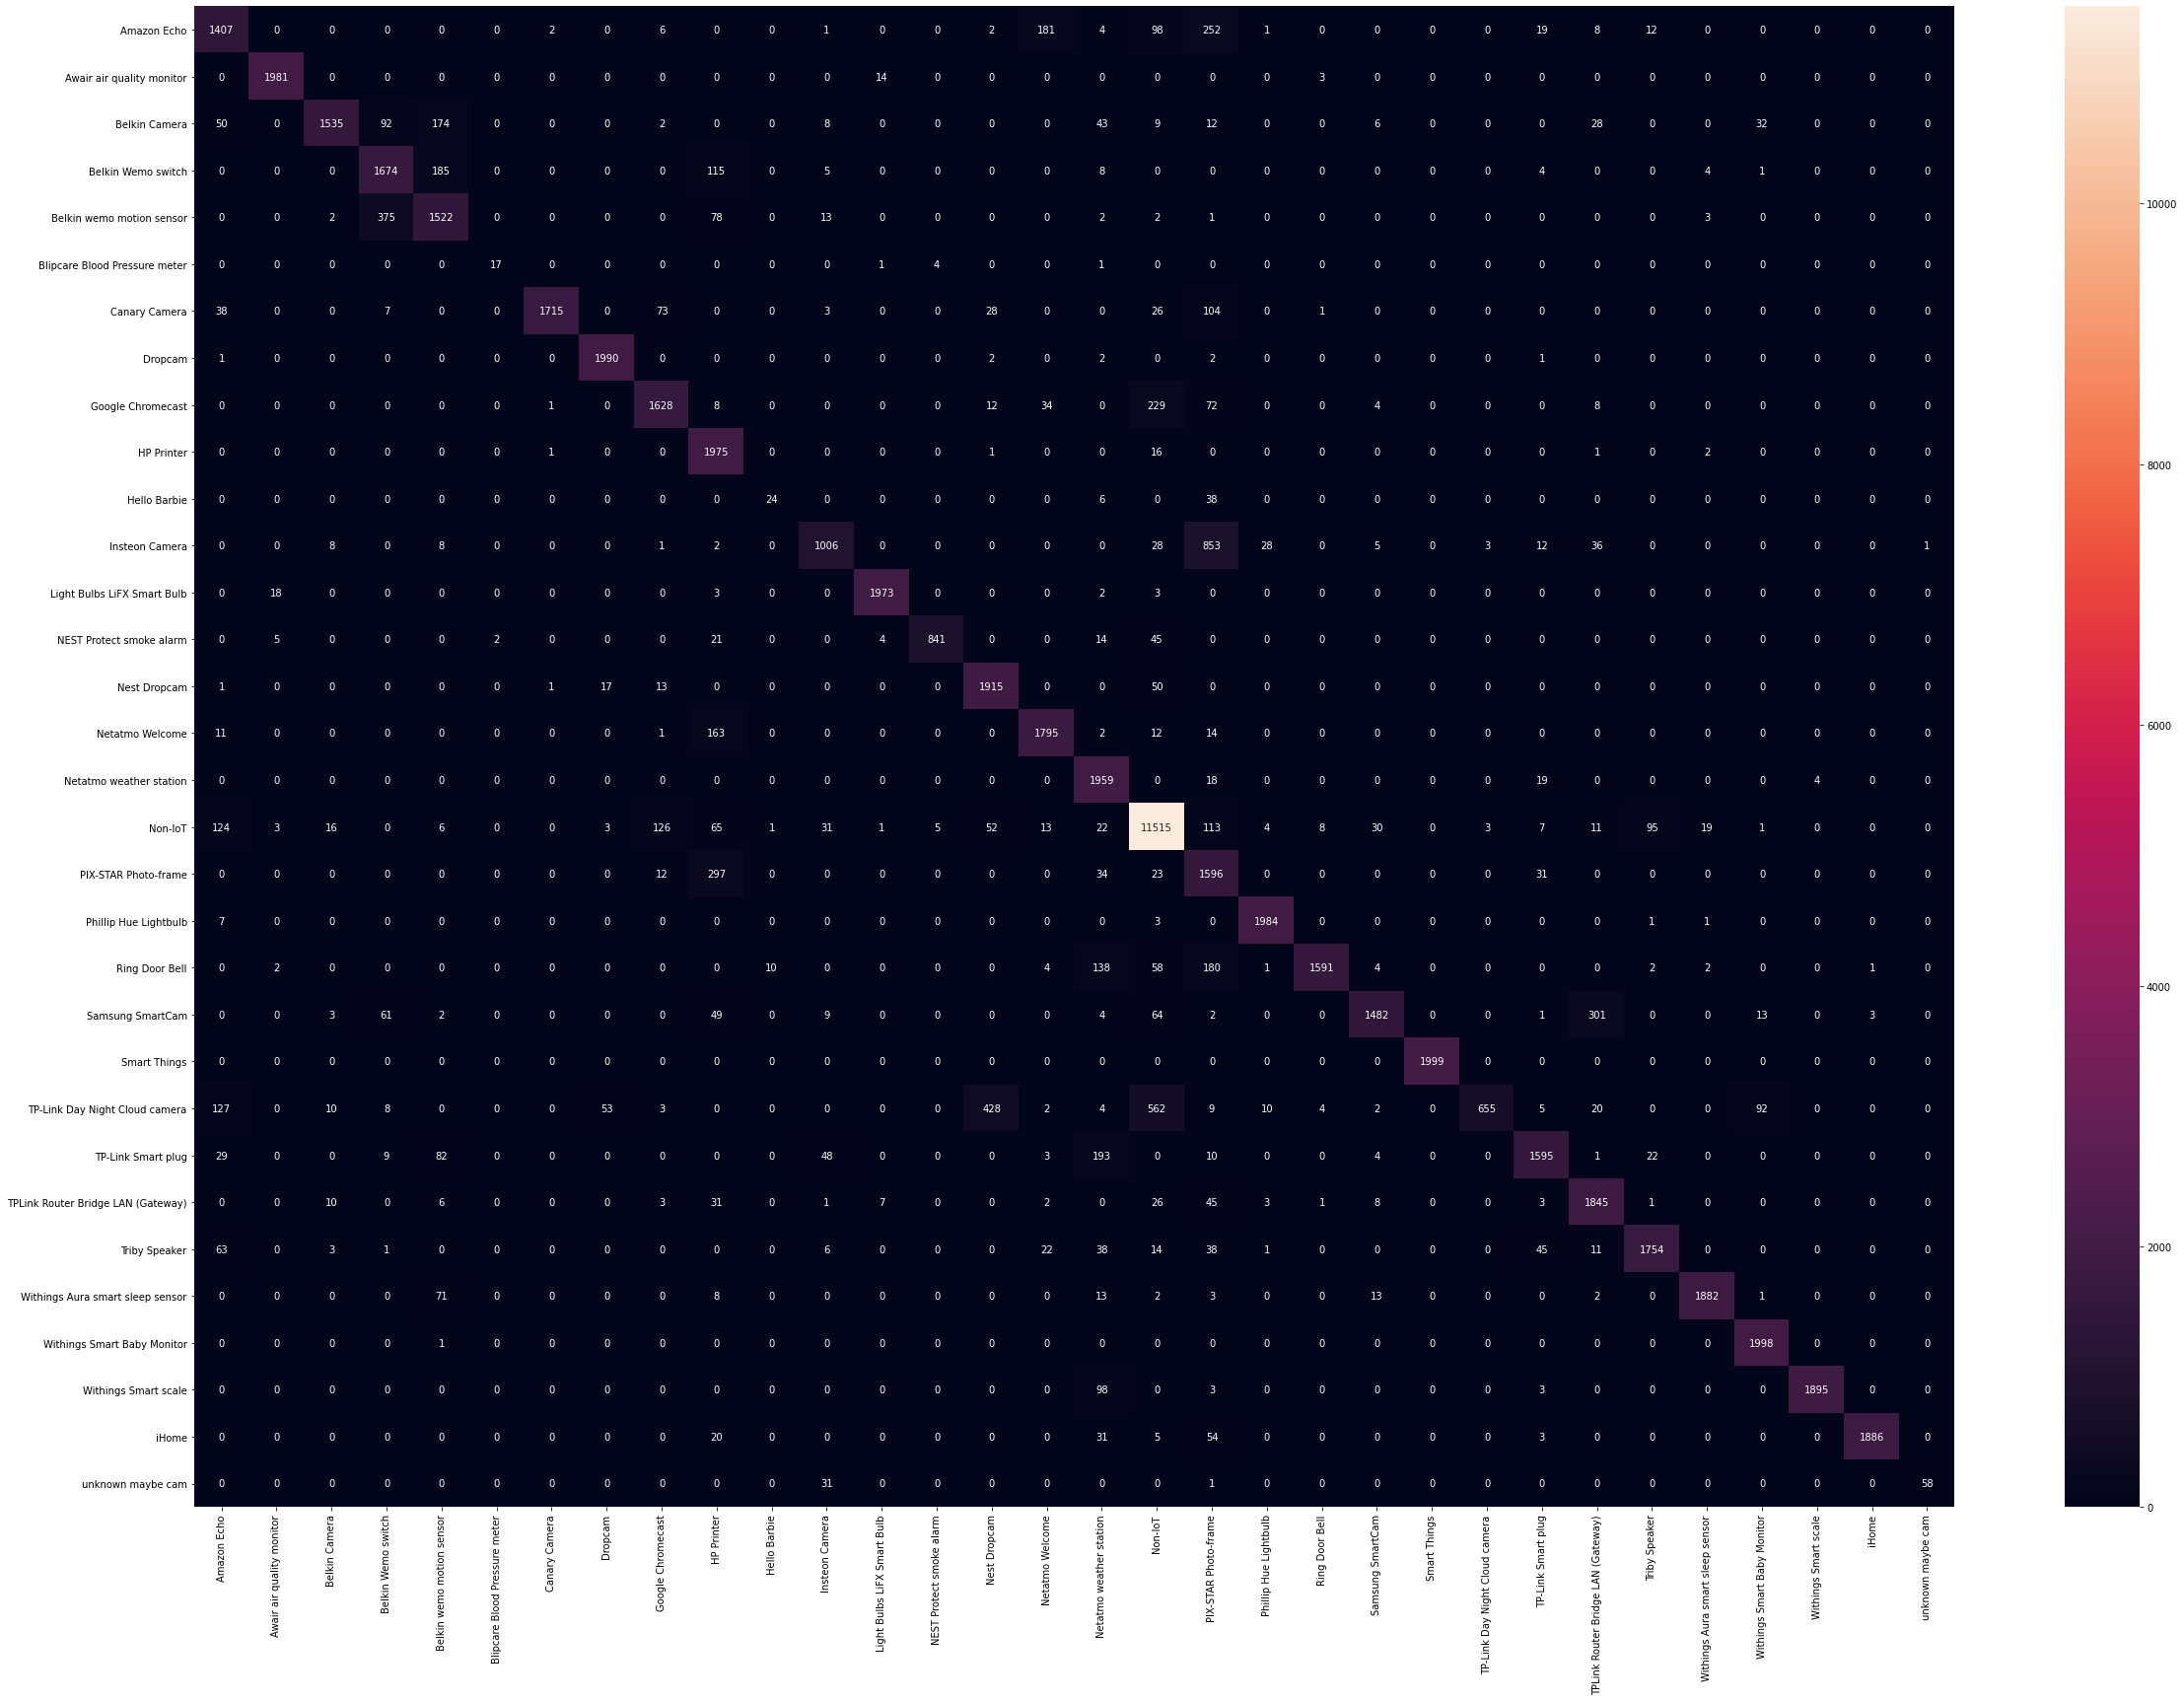





Dataset         T   CV  ML alg  Acc   b_Acc Prec  Rec   F1       kap   tra-T    test-T  total   al-time 
UNSW_1          0   1   RF      0.87  0.83  0.9   0.83  0.8485   0.87  20.78    1.19    21.97   0.0     
UNSW_1          1   2   RF      0.87  0.83  0.9   0.83  0.8491   0.87  20.6     1.22    21.82   0.0     
UNSW_1          2   3   RF      0.87  0.83  0.9   0.83  0.8483   0.86  21.22    1.22    22.44   0.0     
UNSW_1          3   4   RF      0.87  0.83  0.9   0.83  0.8491   0.87  20.79    1.21    22.0    0.0     
UNSW_1          4   5   RF      0.87  0.83  0.9   0.83  0.8494   0.87  20.65    1.16    21.81   0.0     
UNSW_1          5   6   RF      0.87  0.83  0.9   0.83  0.8482   0.87  20.96    1.16    22.13   0.0     
UNSW_1          6   7   RF      0.87  0.83  0.9   0.83  0.8487   0.87  21.23    1.1     22.33   0.0     
UNSW_1          7   8   RF      0.87  0.83  0.9   0.83  0.8489   0.87  24.16    1.47    25.64   0.0     
UNSW_1          8   9   RF      0.87  0.83  0.9   0

UNSW_1          77  78  RF      0.87  0.83  0.9   0.83  0.8489   0.87  23.3     1.53    24.83   0.0     
UNSW_1          78  79  RF      0.87  0.83  0.9   0.83  0.8482   0.87  24.23    1.47    25.69   0.0     
UNSW_1          79  80  RF      0.87  0.83  0.9   0.83  0.8486   0.87  23.27    1.42    24.69   0.0     
UNSW_1          80  81  RF      0.87  0.83  0.9   0.83  0.849    0.87  23.46    1.31    24.77   0.0     
UNSW_1          81  82  RF      0.87  0.83  0.9   0.83  0.8488   0.87  24.34    1.28    25.61   0.0     
UNSW_1          82  83  RF      0.87  0.83  0.9   0.83  0.8489   0.87  23.43    1.43    24.86   0.0     
UNSW_1          83  84  RF      0.87  0.83  0.9   0.83  0.8491   0.87  23.72    1.35    25.07   0.0     
UNSW_1          84  85  RF      0.87  0.83  0.9   0.83  0.8483   0.87  24.2     1.52    25.72   0.0     
UNSW_1          85  86  RF      0.87  0.83  0.9   0.83  0.8484   0.87  24.26    1.34    25.6    0.0     
UNSW_1          86  87  RF      0.87  0.83  0.9   0.83 

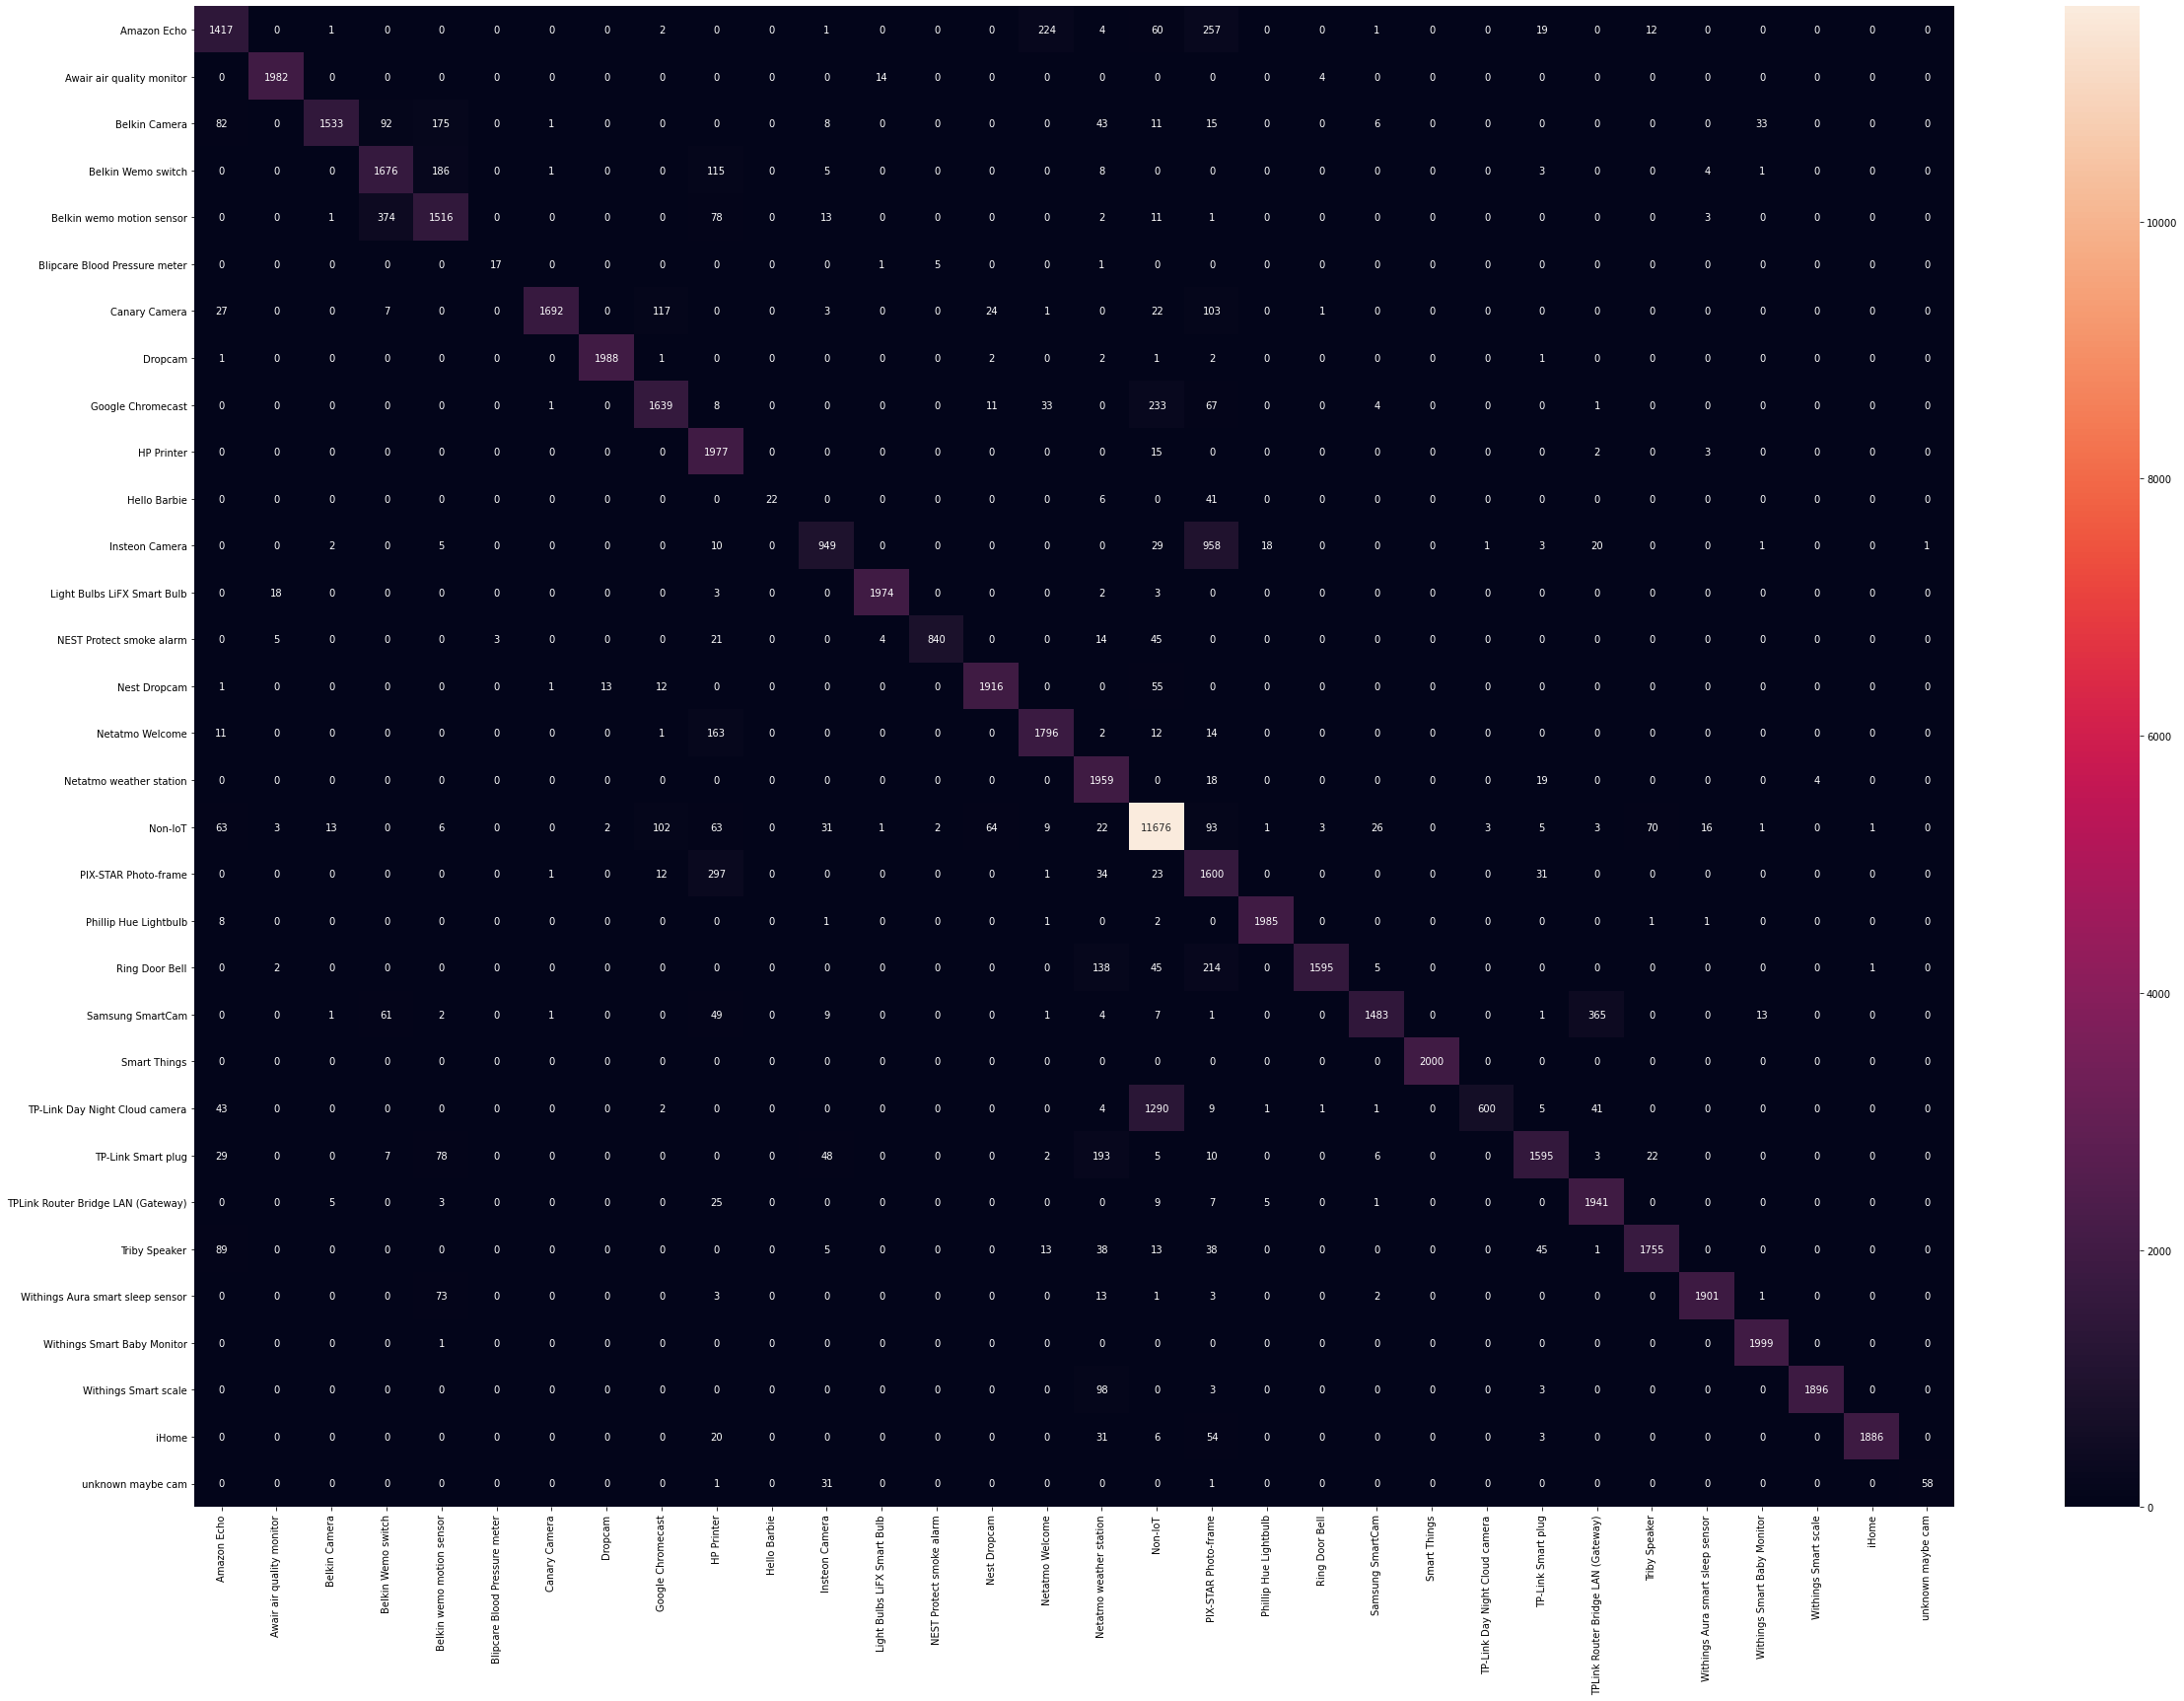

In [9]:
test='UNSW_test_IoTDevID.csv'
train='UNSW_train_IoTDevID.csv'


dataset="./UNSW/"
step=1



mixed=True
sayac=1
output_csv=dataset+str(sayac)+"_"+str(step)+"_"+str(mixed)+".csv"
target_names=target_name(test)
ML(train,test,output_csv,feature,step,mixed,dataset[2:-1]+"_"+str(step))   
